In [1]:
import sys
import os
import re
import pickle
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from transformers import TFBertModel,BertTokenizer
from sklearn.preprocessing import StandardScaler
import sys
import os
import re
import pickle


DATA_PATH = '../data/MOSEI/'

def to_pickle(obj, path):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

def get_length(x):
    return x.shape[1]-(np.sum(x, axis=-1) == 0).sum(1)

# first we align to words with averaging, collapse_function receives a list of functions
# dataset.align(text_field, collapse_functions=[avg])
# load pickle file for unaligned acoustic and visual source
pickle_filename = DATA_PATH+'mosei_senti_data_noalign.pkl'
csv_filename = DATA_PATH+'MOSEI-label.csv'

with open(pickle_filename, 'rb') as f:
    d = pickle.load(f)

# read csv file for label and text
df = pd.read_csv(csv_filename)
text = df['text']
vid = df['video_id']
cid = df['clip_id']

train_split_noalign = d['train']
dev_split_noalign = d['valid']
test_split_noalign = d['test']

# a sentinel epsilon for safe division, without it we will replace illegal values with a constant
EPS = 1e-6

# place holders for the final train/dev/test dataset
train = train = []
dev = dev = []
test = test = []

# define a regular expression to extract the video ID out of the keys
# pattern = re.compile('(.*)\[.*\]')
pattern = re.compile('(.*)_([.*])')
num_drop = 0 # a counter to count how many data points went into some processing issues

v = np.concatenate((train_split_noalign['vision'],dev_split_noalign['vision'], test_split_noalign['vision']),axis=0)
vlens = get_length(v)

a = np.concatenate((train_split_noalign['audio'],dev_split_noalign['audio'], test_split_noalign['audio']),axis=0)
alens = get_length(a)

label = np.concatenate((train_split_noalign['labels'],dev_split_noalign['labels'], test_split_noalign['labels']),axis=0)

L_V = v.shape[1]
L_A = a.shape[1]


all_id = np.concatenate((train_split_noalign['id'], dev_split_noalign['id'], test_split_noalign['id']),axis=0)[:,0]
all_id_list = all_id.tolist()

train_size = len(train_split_noalign['id'])
dev_size = len(dev_split_noalign['id'])
test_size = len(test_split_noalign['id'])

dev_start = train_size
test_start = train_size + dev_size

all_csv_id = [(vid[i], str(cid[i])) for i in range(len(vid))]

for i, idd in enumerate(all_id_list):
    # get the video ID and the features out of the aligned dataset

    # matching process
    try:
        index = i
    except:
        import ipdb; ipdb.set_trace()

    _words = text[index].split()
    _label = label[i].astype(np.float32)
    _visual = v[i]
    _acoustic = a[i]
    _vlen = vlens[i]
    _alen = alens[i]
    _id = '{}[{}]'.format(all_csv_id[0], all_csv_id[1])           

    # remove nan values
    # label = np.nan_to_num(label)
    _visual = np.nan_to_num(_visual)
    _acoustic = np.nan_to_num(_acoustic)

    # remove speech pause tokens - this is in general helpful
    # we should remove speech pauses and corresponding visual/acoustic features together
    # otherwise modalities would no longer be aligned
    actual_words = []
    words = []
    visual = []
    acoustic = []

    for word in _words:
        actual_words.append(word)

    visual = _visual[L_V - _vlen:,:]
    acoustic = _acoustic[L_A - _alen:,:]

    if i < dev_start:
        train.append((words, visual, acoustic, actual_words, _vlen, _alen, _label, idd))
    elif i >= dev_start and i < test_start:
        dev.append((words, visual, acoustic, actual_words, _vlen, _alen, _label, idd))
    elif i >= test_start:
        test.append((words, visual, acoustic, actual_words, _vlen, _alen, _label, idd))
    else:
        print(f"Found video that doesn't belong to any splits: {idd}")


# print(f"Total number of {num_drop} datapoints have been dropped.")
print(f"Total number of {num_drop} datapoints have been dropped.")
print("Dataset split")
print("Train Set: {}".format(len(train)))
print("Validation Set: {}".format(len(dev)))
print("Test Set: {}".format(len(test)))

# Save glove embeddings cache too
# self.pretrained_emb = pretrained_emb = load_emb(word2id, config.word_emb_path)
# torch.save((pretrained_emb, word2id), CACHE_PATH)
pretrained_emb = None

# Save pickles
# to_pickle(train, DATA_PATH + '/dftrain.pkl')
# to_pickle(dev, DATA_PATH + '/dfdev.pkl')
# to_pickle(test, DATA_PATH + '/dftest.pkl')

Total number of 0 datapoints have been dropped.
Dataset split
Train Set: 16326
Validation Set: 1871
Test Set: 4659


In [2]:
train_df = pd.DataFrame(train,columns=['words', 'visual', 'acoustic', 'actual_words', '_vlen', '_alen', '_label', 'idd'])
dev_df = pd.DataFrame(dev,columns=['words', 'visual', 'acoustic', 'actual_words', '_vlen', '_alen', '_label', 'idd'])
test_df = pd.DataFrame(test,columns=['words', 'visual', 'acoustic', 'actual_words', '_vlen', '_alen', '_label', 'idd'])


In [3]:
train_df

,words,visual,acoustic,actual_words,_vlen,_alen,_label,idd
0,[],"[[-1.2108299732208252, -0.46178698539733887, -...","[[194.5, 0.0, 0.07899338752031326, 0.412973552...","[Key, is, part, of, the, people, that, we, use...",267,356,[[1.0]],-3g5yACwYnA
1,[],"[[-1.7858200073242188, -0.6380839943885803, 0....","[[105.5, 1.0, 0.021022265776991844, 0.08599962...","[They've, been, able, to, find, solutions, or,...",81,107,[[0.6666667]],-3g5yACwYnA
2,[],"[[-1.7642099857330322, -0.7958599925041199, -0...","[[106.5, 1.0, 0.11148008704185486, 0.726543664...","[We're, a, huge, user, of, adhesives, for, our...",215,286,[[0.0]],-3g5yACwYnA
3,[],"[[-1.2986199855804443, -0.2510870099067688, -0...","[[115.5, 1.0, 0.057251088321208954, 0.33875322...","[Key, Polymer, brings, a, technical, aspect, t...",138,184,[[0.0]],-3g5yACwYnA
4,[],"[[-1.6502399444580078, -0.3371959924697876, -0...","[[100.5, 1.0, 0.14517584443092346, 0.675116181...","[Key, brings, those, types, of, aspects, to, a...",221,295,[[1.0]],-3g5yACwYnA
...,...,...,...,...,...,...,...,...
16321,[],"[[-1.8842400312423706, -0.6028929948806763, 0....","[[127.5, 1.0, 0.11853820085525513, 0.720579862...","[I, read, other, articles,, what, other, train...",72,103,[[0.0]],zwTrXwi54us
16322,[],"[[-2.153140068054199, -0.04792049899697304, -0...","[[129.5, 1.0, 0.1991356760263443, 0.6945900321...","[I, do, all, of, that]",28,37,[[0.0]],zwTrXwi54us
16323,[],"[[-4.401090145111084, -1.0127899646759033, -1....","[[188.5, 0.0, 0.05910159647464752, 0.331484466...","[Now,, if, this, sounds, like, something, you'...",163,227,[[0.6666667]],zwTrXwi54us
16324,[],"[[-2.3272500038146973, -1.1171799898147583, 0....","[[133.0, 0.0, 0.027281710878014565, 0.07664652...","[I, actually, speak, to, the, experts, myself,...",80,106,[[1.0]],zwTrXwi54us


Auto Encoder
=======================================================================================================================================
---------------------------------------------------------------------------------------------------------------------------------------

In [4]:
# Encode text data using BERT tokenizer
def encode_text_data(text_data, max_length=500):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    input_ids = []
    attention_masks = []

    for text in text_data:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,  # Set max_length to 500 for BERT base model
            padding='max_length',
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = tf.concat(input_ids, axis=0)
    attention_masks = tf.concat(attention_masks, axis=0)

    return input_ids, attention_masks

def addPadding(df, colName, dim):
    max_length_x = df[colName].apply(lambda x: x.shape[0] if isinstance(x, np.ndarray) else 0).max()

    # Perform padding within the DataFrame
    df[colName] = df[colName].apply(lambda x: np.vstack([x, np.zeros((max_length_x - x.shape[0], dim))]) if isinstance(x, np.ndarray) else x)



def processText(text):
    return ' '.join(text)

def preprocessData(df):
    # addPadding(df,'visual',35)
    # addPadding(df,'acoustic',74)

    df['words'] = df['actual_words'].apply(processText)

    # Preprocess text data and create a tf.data.Dataset
    text_data = encode_text_data(df['words'].tolist())

    # Prepare the rest of the data
    # acoustic_data = np.stack(df['acoustic'])
    # visual_data = np.stack(df['visual'])
    label_data = np.array([label[0] for label in df['_label']])

    # Unpack the text_data into input_ids_data and attention_mask_data
    input_ids_data, attention_mask_data = text_data
    input_ids_data = input_ids_data.numpy().astype(np.int32)
    attention_mask_data = attention_mask_data.numpy().astype(np.int32)

    # Convert the label_data to float32 as it is expected for regression
    label_data = label_data.astype(np.float32)
    return { 'textData':[input_ids_data, attention_mask_data],'Label_denorm':label_data}

In [5]:
np.shape(train_df['acoustic'][15])

(147, 74)

In [6]:
np.shape(train_df['visual'][15])

(64, 35)

In [7]:
modelTrainData = preprocessData(train_df)
modelValData = preprocessData(dev_df)
modelTestData = preprocessData(test_df)

2023-08-27 03:19:58.358513: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-27 03:19:58.358652: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



In [8]:

def flatten_2d_array(arr_2d):
    arr_1d = []
    for row in arr_2d:
        for item in row:
            arr_1d.append(item)
    return arr_1d

train_df['acoustic'] = train_df['acoustic'].apply(flatten_2d_array)
train_df['visual'] = train_df['visual'].apply(flatten_2d_array)
dev_df['acoustic'] = dev_df['acoustic'].apply(flatten_2d_array)
dev_df['visual'] = dev_df['visual'].apply(flatten_2d_array)
test_df['acoustic'] = test_df['acoustic'].apply(flatten_2d_array)
test_df['visual'] = test_df['visual'].apply(flatten_2d_array)

In [9]:
train_df

,words,visual,acoustic,actual_words,_vlen,_alen,_label,idd
0,Key is part of the people that we use to solve...,"[-1.2108299732208252, -0.46178698539733887, -0...","[194.5, 0.0, 0.07899338752031326, 0.4129735529...","[Key, is, part, of, the, people, that, we, use...",267,356,[[1.0]],-3g5yACwYnA
1,They've been able to find solutions or at leas...,"[-1.7858200073242188, -0.6380839943885803, 0.7...","[105.5, 1.0, 0.021022265776991844, 0.085999622...","[They've, been, able, to, find, solutions, or,...",81,107,[[0.6666667]],-3g5yACwYnA
2,We're a huge user of adhesives for our operati...,"[-1.7642099857330322, -0.7958599925041199, -0....","[106.5, 1.0, 0.11148008704185486, 0.7265436649...","[We're, a, huge, user, of, adhesives, for, our...",215,286,[[0.0]],-3g5yACwYnA
3,Key Polymer brings a technical aspect to our o...,"[-1.2986199855804443, -0.2510870099067688, -0....","[115.5, 1.0, 0.057251088321208954, 0.338753223...","[Key, Polymer, brings, a, technical, aspect, t...",138,184,[[0.0]],-3g5yACwYnA
4,Key brings those types of aspects to a busines...,"[-1.6502399444580078, -0.3371959924697876, -0....","[100.5, 1.0, 0.14517584443092346, 0.6751161813...","[Key, brings, those, types, of, aspects, to, a...",221,295,[[1.0]],-3g5yACwYnA
...,...,...,...,...,...,...,...,...
16321,"I read other articles, what other trainers in ...","[-1.8842400312423706, -0.6028929948806763, 0.6...","[127.5, 1.0, 0.11853820085525513, 0.7205798625...","[I, read, other, articles,, what, other, train...",72,103,[[0.0]],zwTrXwi54us
16322,I do all of that,"[-2.153140068054199, -0.04792049899697304, -0....","[129.5, 1.0, 0.1991356760263443, 0.69459003210...","[I, do, all, of, that]",28,37,[[0.0]],zwTrXwi54us
16323,"Now, if this sounds like something you're inte...","[-4.401090145111084, -1.0127899646759033, -1.5...","[188.5, 0.0, 0.05910159647464752, 0.3314844667...","[Now,, if, this, sounds, like, something, you'...",163,227,[[0.6666667]],zwTrXwi54us
16324,I actually speak to the experts myself to give...,"[-2.3272500038146973, -1.1171799898147583, 0.2...","[133.0, 0.0, 0.027281710878014565, 0.076646529...","[I, actually, speak, to, the, experts, myself,...",80,106,[[1.0]],zwTrXwi54us


In [10]:
accusticMaxTrain = train_df['acoustic'].apply(len).max()
accusticMaxDev = dev_df['acoustic'].apply(len).max()
accusticMaxTest = test_df['acoustic'].apply(len).max()
visualMaxTrain = train_df['visual'].apply(len).max()
visualMaxDev = dev_df['visual'].apply(len).max()
visualMaxTest = test_df['visual'].apply(len).max()

In [11]:
accusticMaxTrain

37000

In [12]:
accusticMaxDev

37000

In [13]:
accusticMaxTest

37000

In [14]:
visualMaxTrain

17500

In [15]:
visualMaxDev

17500

In [16]:
visualMaxTest

17500

In [17]:
train_df['acoustic'] = train_df['acoustic'].apply(lambda arr: arr + [0] * (accusticMaxTrain - len(arr)))
dev_df['acoustic'] = dev_df['acoustic'].apply(lambda arr: arr + [0] * (accusticMaxDev - len(arr)))
test_df['acoustic'] = test_df['acoustic'].apply(lambda arr: arr + [0] * (accusticMaxTest - len(arr)))
train_df['visual'] = train_df['visual'].apply(lambda arr: arr + [0] * (visualMaxTrain - len(arr)))
dev_df['visual'] = dev_df['visual'].apply(lambda arr: arr + [0] * (visualMaxDev - len(arr)))
test_df['visual'] = test_df['visual'].apply(lambda arr: arr + [0] * (visualMaxTest - len(arr)))

In [18]:
np.shape(train_df['visual'][3])

(17500,)

In [19]:
train_df['visual']

0        [-1.2108299732208252, -0.46178698539733887, -0...
1        [-1.7858200073242188, -0.6380839943885803, 0.7...
2        [-1.7642099857330322, -0.7958599925041199, -0....
3        [-1.2986199855804443, -0.2510870099067688, -0....
4        [-1.6502399444580078, -0.3371959924697876, -0....
                               ...                        
16321    [-1.8842400312423706, -0.6028929948806763, 0.6...
16322    [-2.153140068054199, -0.04792049899697304, -0....
16323    [-4.401090145111084, -1.0127899646759033, -1.5...
16324    [-2.3272500038146973, -1.1171799898147583, 0.2...
16325    [-1.8243299722671509, -0.061710700392723083, -...
Name: visual, Length: 16326, dtype: object

In [20]:
all_arrays_label = np.vstack(flatten_2d_array(modelTrainData['Label_denorm']) + flatten_2d_array(modelValData['Label_denorm']) + flatten_2d_array(modelTestData['Label_denorm']))

# Calculate the overall label minimum and maximum values
label_min = np.min(all_arrays_label)
label_max = np.max(all_arrays_label)

print("Overall Label Minimum:", label_min)
print("Overall Label Maximum:", label_max)

Overall Label Minimum: -3.0
Overall Label Maximum: 3.0


In [21]:
# Combine all arrays into a single array
all_arrays_visual = np.vstack([train_df['visual'].tolist()+dev_df['visual'].tolist()+test_df['visual'].tolist()])
all_arrays_acoustic = np.vstack([train_df['acoustic'].tolist()+dev_df['acoustic'].tolist()+test_df['acoustic'].tolist()])

# Calculate the overall visual minimum and maximum values
visual_min = np.min(all_arrays_visual)
visual_max = np.max(all_arrays_visual)

# Calculate the overall acoustic minimum and maximum values
acoustic_min = np.min(all_arrays_acoustic)
acoustic_max = np.max(all_arrays_acoustic)

In [22]:
print("Overall Visual Minimum:", visual_min)
print("Overall Visual Maximum:", visual_max)

print("Overall Acoustic Minimum:", acoustic_min)
print("Overall Acoustic Maximum:", acoustic_max)


Overall Visual Minimum: -39.62459945678711
Overall Visual Maximum: 31.594900131225586
Overall Acoustic Minimum: -60.02680587768555
Overall Acoustic Maximum: 500.0


In [23]:
def minmax_normalize(arr, min_val, max_val):
    return (arr - min_val) / (max_val - min_val)
def minmax_denormalize(arr_normalized, min_val, max_val):
    return arr_normalized * (max_val - min_val) + min_val

In [24]:
train_df['visual_normalized'] = [minmax_normalize(arr, visual_min, visual_max) for arr in train_df['visual']]
dev_df['visual_normalized'] = [minmax_normalize(arr, visual_min, visual_max) for arr in dev_df['visual']]
test_df['visual_normalized'] = [minmax_normalize(arr, visual_min, visual_max) for arr in test_df['visual']]

train_df['acoustic_normalized'] = [minmax_normalize(arr, acoustic_min, acoustic_max) for arr in train_df['acoustic']]
dev_df['acoustic_normalized'] = [minmax_normalize(arr, acoustic_min, acoustic_max) for arr in dev_df['acoustic']]
test_df['acoustic_normalized'] = [minmax_normalize(arr, acoustic_min, acoustic_max) for arr in test_df['acoustic']]


In [25]:
modelTrainData['Label'] = np.array([[minmax_normalize(arr[0], label_min, label_max)] for arr in modelTrainData['Label_denorm']])
modelValData['Label'] = np.array([[minmax_normalize(arr[0], label_min, label_max)] for arr in modelValData['Label_denorm']])
modelTestData['Label'] = np.array([[minmax_normalize(arr[0], label_min, label_max)] for arr in modelTestData['Label_denorm']])

In [26]:
train_df['visual_normalized']

0        [0.5393715163091639, 0.5498889025889963, 0.549...
1        [0.5312980246751372, 0.5474134989423675, 0.566...
2        [0.531601453114205, 0.5451981506314661, 0.5429...
3        [0.5381388481091982, 0.552847361672666, 0.5556...
4        [0.5332017176756568, 0.5516382969774472, 0.545...
                               ...                        
16321    [0.5299160994371407, 0.5479076192284054, 0.565...
16322    [0.5261404475669739, 0.5557000426390455, 0.544...
16323    [0.4945767593908322, 0.5421522155515138, 0.534...
16324    [0.5236957528307333, 0.540686464939073, 0.5602...
16325    [0.5307573024689197, 0.5555064130646238, 0.544...
Name: visual_normalized, Length: 16326, dtype: object

In [27]:
train_df['visual']

0        [-1.2108299732208252, -0.46178698539733887, -0...
1        [-1.7858200073242188, -0.6380839943885803, 0.7...
2        [-1.7642099857330322, -0.7958599925041199, -0....
3        [-1.2986199855804443, -0.2510870099067688, -0....
4        [-1.6502399444580078, -0.3371959924697876, -0....
                               ...                        
16321    [-1.8842400312423706, -0.6028929948806763, 0.6...
16322    [-2.153140068054199, -0.04792049899697304, -0....
16323    [-4.401090145111084, -1.0127899646759033, -1.5...
16324    [-2.3272500038146973, -1.1171799898147583, 0.2...
16325    [-1.8243299722671509, -0.061710700392723083, -...
Name: visual, Length: 16326, dtype: object

In [28]:
modelTrainData['Label']

array([[0.6666667],
       [0.6111111],
       [0.5      ],
       ...,
       [0.6111111],
       [0.6666667],
       [0.6666667]], dtype=float32)

In [29]:
train_df

,words,visual,acoustic,actual_words,_vlen,_alen,_label,idd,visual_normalized,acoustic_normalized
0,Key is part of the people that we use to solve...,"[-1.2108299732208252, -0.46178698539733887, -0...","[194.5, 0.0, 0.07899338752031326, 0.4129735529...","[Key, is, part, of, the, people, that, we, use...",267,356,[[1.0]],-3g5yACwYnA,"[0.5393715163091639, 0.5498889025889963, 0.549...","[0.45449039797083624, 0.10718559406028842, 0.1..."
1,They've been able to find solutions or at leas...,"[-1.7858200073242188, -0.6380839943885803, 0.7...","[105.5, 1.0, 0.021022265776991844, 0.085999622...","[They've, been, able, to, find, solutions, or,...",81,107,[[0.6666667]],-3g5yACwYnA,"[0.5312980246751372, 0.5474134989423675, 0.566...","[0.2955694337135676, 0.10897122287216784, 0.10..."
2,We're a huge user of adhesives for our operati...,"[-1.7642099857330322, -0.7958599925041199, -0....","[106.5, 1.0, 0.11148008704185486, 0.7265436649...","[We're, a, huge, user, of, adhesives, for, our...",215,286,[[0.0]],-3g5yACwYnA,"[0.531601453114205, 0.5451981506314661, 0.5429...","[0.29735506252544697, 0.10897122287216784, 0.1..."
3,Key Polymer brings a technical aspect to our o...,"[-1.2986199855804443, -0.2510870099067688, -0....","[115.5, 1.0, 0.057251088321208954, 0.338753223...","[Key, Polymer, brings, a, technical, aspect, t...",138,184,[[0.0]],-3g5yACwYnA,"[0.5381388481091982, 0.552847361672666, 0.5556...","[0.3134257218323618, 0.10897122287216784, 0.10..."
4,Key brings those types of aspects to a busines...,"[-1.6502399444580078, -0.3371959924697876, -0....","[100.5, 1.0, 0.14517584443092346, 0.6751161813...","[Key, brings, those, types, of, aspects, to, a...",221,295,[[1.0]],-3g5yACwYnA,"[0.5332017176756568, 0.5516382969774472, 0.545...","[0.28664128965417046, 0.10897122287216784, 0.1..."
...,...,...,...,...,...,...,...,...,...,...
16321,"I read other articles, what other trainers in ...","[-1.8842400312423706, -0.6028929948806763, 0.6...","[127.5, 1.0, 0.11853820085525513, 0.7205798625...","[I, read, other, articles,, what, other, train...",72,103,[[0.0]],zwTrXwi54us,"[0.5299160994371407, 0.5479076192284054, 0.565...","[0.33485326757491485, 0.10897122287216784, 0.1..."
16322,I do all of that,"[-2.153140068054199, -0.04792049899697304, -0....","[129.5, 1.0, 0.1991356760263443, 0.69459003210...","[I, do, all, of, that]",28,37,[[0.0]],zwTrXwi54us,"[0.5261404475669739, 0.5557000426390455, 0.544...","[0.3384245251986737, 0.10897122287216784, 0.10..."
16323,"Now, if this sounds like something you're inte...","[-4.401090145111084, -1.0127899646759033, -1.5...","[188.5, 0.0, 0.05910159647464752, 0.3314844667...","[Now,, if, this, sounds, like, something, you'...",163,227,[[0.6666667]],zwTrXwi54us,"[0.4945767593908322, 0.5421522155515138, 0.534...","[0.4437766250995597, 0.10718559406028842, 0.10..."
16324,I actually speak to the experts myself to give...,"[-2.3272500038146973, -1.1171799898147583, 0.2...","[133.0, 0.0, 0.027281710878014565, 0.076646529...","[I, actually, speak, to, the, experts, myself,...",80,106,[[1.0]],zwTrXwi54us,"[0.5236957528307333, 0.540686464939073, 0.5602...","[0.3446742260402517, 0.10718559406028842, 0.10..."


In [30]:
import numpy as np
import tensorflow as tf

class Create_audio_autoencoder(tf.keras.models.Model):
    def __init__(self):

        super(Create_audio_autoencoder, self).__init__()

        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(37000,)),
            tf.keras.layers.Dense(18500, activation='sigmoid'),
            # tf.keras.layers.Dense(9250, activation='relu')
        ])

        self.decoder = tf.keras.Sequential([
            # tf.keras.layers.Dense(18500, activation='relu'),
            tf.keras.layers.Dense(37000, activation='sigmoid')
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return decoded

class Create_visual_autoencoder(tf.keras.models.Model):
    def __init__(self):

        super(Create_visual_autoencoder, self).__init__()

        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(17500,)),
            tf.keras.layers.Dense(8750, activation='relu'),
            # tf.keras.layers.Dense(4375, activation='relu')
        ])

        self.decoder = tf.keras.Sequential([
            # tf.keras.layers.Dense(8750, activation='relu'),
            tf.keras.layers.Dense(17500, activation='sigmoid')
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return decoded
        
# Create autoencoders
audio_autoencoder = Create_audio_autoencoder()
visual_autoencoder = Create_visual_autoencoder()


In [31]:
# Convert DataFrame columns to TensorFlow tensors
train_acoustic_normalized = tf.convert_to_tensor(train_df['acoustic_normalized'].tolist(), dtype=tf.float32)
dev_acoustic_normalized = tf.convert_to_tensor(dev_df['acoustic_normalized'].tolist(), dtype=tf.float32)


In [38]:
audio_autoencoder.build((None, 37000))
visual_autoencoder.build((None, 17500))

In [39]:
# Compile audio autoencoder
audio_autoencoder.compile(optimizer='adam', loss='mean_squared_error',metrics=['mean_absolute_error'])

In [33]:

# Train visual autoencoder
audio_autoencoder.fit(
    train_acoustic_normalized,
    train_acoustic_normalized,
    epochs=1,
    batch_size=32,
    shuffle=True,
    validation_data=(dev_acoustic_normalized, dev_acoustic_normalized)
)


2023-08-27 03:18:51.579634: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-27 03:18:54.481447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 67/511 [==>...........................] - ETA: 3:09 - loss: 0.1132 - mean_absolute_error: 0.3074

In [ ]:
audio_autoencoder.save_weights('audio_autoencoder.h5')

In [40]:
audio_autoencoder.load_weights('audio_autoencoder.h5')

In [41]:
# Convert DataFrame columns to TensorFlow tensors
train_visual_normalized = tf.convert_to_tensor(train_df['visual_normalized'].tolist(), dtype=tf.float32)
dev_visual_normalized = tf.convert_to_tensor(dev_df['visual_normalized'].tolist(), dtype=tf.float32)


In [42]:
# compiling visual autoencoder
visual_autoencoder.compile(optimizer='adam', loss='mean_squared_error',metrics=['mean_absolute_error'])

In [ ]:
# Train acustic autoencoders
visual_autoencoder.fit(
    train_visual_normalized,
    train_visual_normalized,
    epochs=10,
    batch_size=32,
    shuffle=True,
    validation_data=(dev_visual_normalized, dev_visual_normalized)
)

Epoch 1/10


2023-08-23 20:26:28.169421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


511/511 [==============================] - ETA: 0s - loss: 4.2369e-04 - accuracy: 8.5753e-04 - mean_absolute_error: 0.0079

2023-08-23 20:27:22.033603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


511/511 [==============================] - 55s 107ms/step - loss: 4.2369e-04 - accuracy: 8.5753e-04 - mean_absolute_error: 0.0079 - val_loss: 2.9457e-04 - val_accuracy: 0.0027 - val_mean_absolute_error: 0.0062
Epoch 2/10
511/511 [==============================] - 53s 104ms/step - loss: 2.7452e-04 - accuracy: 0.0014 - mean_absolute_error: 0.0061 - val_loss: 2.8288e-04 - val_accuracy: 5.3447e-04 - val_mean_absolute_error: 0.0062
Epoch 3/10
511/511 [==============================] - 53s 104ms/step - loss: 2.5215e-04 - accuracy: 0.0033 - mean_absolute_error: 0.0061 - val_loss: 2.3202e-04 - val_accuracy: 0.0059 - val_mean_absolute_error: 0.0056
Epoch 4/10
511/511 [==============================] - 54s 105ms/step - loss: 2.2702e-04 - accuracy: 0.0076 - mean_absolute_error: 0.0057 - val_loss: 2.2207e-04 - val_accuracy: 0.0080 - val_mean_absolute_error: 0.0057
Epoch 5/10
511/511 [==============================] - 53s 103ms/step - loss: 2.2607e-04 - accuracy: 0.0058 - mean_absolute_error: 0.005

In [ ]:
visual_autoencoder.save_weights('visual_autoencoder.h5')

In [43]:
visual_autoencoder.load_weights('visual_autoencoder.h5')

In [44]:
# Convert DataFrame columns to TensorFlow tensors

test_acoustic_normalized = tf.convert_to_tensor(test_df['acoustic_normalized'].tolist(), dtype=tf.float32)
test_visual_normalized = tf.convert_to_tensor(test_df['visual_normalized'].tolist(), dtype=tf.float32)


In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, f1_score

visual_autoencoder_predictions = visual_autoencoder.predict(test_visual_normalized)
visual_mse = mean_squared_error(test_visual_normalized, visual_autoencoder_predictions)
visual_mae = mean_absolute_error(test_visual_normalized, visual_autoencoder_predictions)

print("Mean Squared Error:", visual_mse)
print("Mean Absolute Error:", visual_mae)

146/146 [==============================] - 2s 17ms/step
Mean Squared Error: 0.00021735395
Mean Absolute Error: 0.005861344


In [48]:
visual_autoencoder_predictions

array([[0.5277634 , 0.5391883 , 0.54541576, ..., 0.5560055 , 0.55774456,
        0.55709016],
       [0.53049886, 0.5415843 , 0.5477496 , ..., 0.55775976, 0.5594362 ,
        0.558759  ],
       [0.52945   , 0.5405634 , 0.5467851 , ..., 0.55703825, 0.5587172 ,
        0.5580613 ],
       ...,
       [0.5283435 , 0.53818566, 0.54488134, ..., 0.5556544 , 0.5570629 ,
        0.55658996],
       [0.5260107 , 0.5331684 , 0.54086465, ..., 0.552735  , 0.5535721 ,
        0.55348563],
       [0.52803427, 0.5369292 , 0.543946  , ..., 0.5549844 , 0.556193  ,
        0.5558442 ]], dtype=float32)

In [49]:
test_visual_normalized

<tf.Tensor: shape=(4659, 17500), dtype=float32, numpy=
array([[0.5563729 , 0.5563729 , 0.5563729 , ..., 0.5563729 , 0.5563729 ,
        0.5563729 ],
       [0.5711742 , 0.5437265 , 0.54679555, ..., 0.5563729 , 0.5563729 ,
        0.5563729 ],
       [0.54695755, 0.57714516, 0.53652537, ..., 0.5563729 , 0.5563729 ,
        0.5563729 ],
       ...,
       [0.49155146, 0.49578163, 0.5142577 , ..., 0.5563729 , 0.5563729 ,
        0.5563729 ],
       [0.4790709 , 0.43330434, 0.5136048 , ..., 0.5563729 , 0.5563729 ,
        0.5563729 ],
       [0.5080169 , 0.44718552, 0.5561996 , ..., 0.5563729 , 0.5563729 ,
        0.5563729 ]], dtype=float32)>

In [50]:

acustic_autoencoder_predictions = audio_autoencoder.predict(test_acoustic_normalized)
acustic_mse = mean_squared_error(test_acoustic_normalized, acustic_autoencoder_predictions)
acustic_mae = mean_absolute_error(test_acoustic_normalized, acustic_autoencoder_predictions)

print("Mean Squared Error:", acustic_mse)
print("Mean Absolute Error:", acustic_mae)

  1/146 [..............................] - ETA: 12s

2023-08-27 03:30:16.042913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


146/146 [==============================] - 12s 79ms/step
Mean Squared Error: 0.0026780884
Mean Absolute Error: 0.0267388


In [51]:
test_acoustic_normalized

<tf.Tensor: shape=(4659, 37000), dtype=float32, numpy=
array([[0.3928862 , 0.10718559, 0.10721393, ..., 0.10718559, 0.10718559,
        0.10718559],
       [0.2803916 , 0.10897122, 0.10723966, ..., 0.10718559, 0.10718559,
        0.10718559],
       [0.30181915, 0.10718559, 0.10718559, ..., 0.10718559, 0.10718559,
        0.10718559],
       ...,
       [0.66162336, 0.10718559, 0.10736787, ..., 0.10718559, 0.10718559,
        0.10718559],
       [0.5750203 , 0.10897122, 0.10751038, ..., 0.10718559, 0.10718559,
        0.10718559],
       [0.750012  , 0.10897122, 0.10725091, ..., 0.10718559, 0.10718559,
        0.10718559]], dtype=float32)>

In [52]:
acustic_autoencoder_predictions

array([[2.57759750e-01, 1.19529446e-07, 2.63436721e-08, ...,
        1.09322719e-01, 1.06109597e-01, 1.05204798e-01],
       [2.33680144e-01, 1.18624257e-07, 2.62066049e-08, ...,
        1.08811311e-01, 1.05882972e-01, 1.05136178e-01],
       [2.42503315e-01, 1.17011687e-07, 2.61683439e-08, ...,
        1.06735349e-01, 1.06527776e-01, 1.04344755e-01],
       ...,
       [5.59828579e-01, 1.26736097e-07, 2.86295645e-08, ...,
        1.07545145e-01, 1.07920744e-01, 1.07943691e-01],
       [4.23325241e-01, 1.22470240e-07, 2.72850365e-08, ...,
        1.09382607e-01, 1.05654359e-01, 1.08239017e-01],
       [4.39187378e-01, 1.25476930e-07, 2.82064629e-08, ...,
        1.07135370e-01, 1.07630871e-01, 1.06306113e-01]], dtype=float32)

In [53]:
train_acoustic_normalized[0]

<tf.Tensor: shape=(37000,), dtype=float32, numpy=
array([0.4544904 , 0.10718559, 0.10732665, ..., 0.10718559, 0.10718559,
       0.10718559], dtype=float32)>

In [54]:
# audio_encoder = tf.keras.models.Model(inputs=audio_autoencoder.input, outputs=audio_autoencoder.layers[2].output)
# visual_encoder = tf.keras.models.Model(inputs=visual_autoencoder.input, outputs=visual_autoencoder.layers[2].output)

# Predict encoded values
encoded_audio_data_train = audio_autoencoder.encoder(train_acoustic_normalized)
encoded_visual_data_train = visual_autoencoder.encoder(train_visual_normalized)

print("Encoded Audio Data Shape:", encoded_audio_data_train.shape)
print("Encoded Visual Data Shape:", encoded_visual_data_train.shape)

Encoded Audio Data Shape: (16326, 18500)
Encoded Visual Data Shape: (16326, 8750)


In [55]:
np.shape(modelTrainData['Label'])

(16326, 1)

In [56]:

encoded_audio_data_val = audio_autoencoder.encoder(dev_acoustic_normalized)
encoded_visual_data_val = visual_autoencoder.encoder(dev_visual_normalized)

In [57]:
input_shape1 = (16326, 9250)
input_shape1[1:]

(9250,)

In [58]:
encoded_audio_data_val[0]

<tf.Tensor: shape=(18500,), dtype=float32, numpy=
array([0.9973482 , 0.9996753 , 0.33161014, ..., 0.468815  , 0.35748327,
       0.7078165 ], dtype=float32)>

In [59]:
encoded_audio_data_test = audio_autoencoder.encoder(test_acoustic_normalized)
encoded_visual_data_test = visual_autoencoder.encoder(test_visual_normalized)

In [117]:
import tensorflow as tf
import numpy as np

# Define the MLP architecture
input_layer1 = tf.keras.layers.Input(shape=(18500,))
input_layer2 = tf.keras.layers.Input(shape=(8750,))

# Combine input layers
combined_input = tf.keras.layers.Concatenate(axis=-1)([input_layer1, input_layer2])


# hidden_layer1 = tf.keras.layers.Dense(6800, activation='sigmoid')(combined_input)
hidden_layer2 = tf.keras.layers.Dense(128, activation='sigmoid')(combined_input)

output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(hidden_layer2)

# Create the model
model_final = tf.keras.Model(inputs=[input_layer1, input_layer2], outputs=output_layer)


In [118]:
# Compile the model
model_final.compile(optimizer='adam', loss='mean_squared_error',metrics=['mean_absolute_error'])
# Print model summary
model_final.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 18500)]      0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 8750)]       0           []                               
                                                                                                  
 concatenate_4 (Concatenate)    (None, 27250)        0           ['input_11[0][0]',               
                                                                  'input_12[0][0]']               
                                                                                                  
 dense_13 (Dense)               (None, 128)          3488128     ['concatenate_4[0][0]']    

In [119]:

# Train the model
model_final.fit(
    [encoded_audio_data_train, encoded_visual_data_train], 
    modelTrainData['Label'], 
    epochs=2, 
    # batch_size=32,
    shuffle=True,
    validation_data=([encoded_audio_data_val, encoded_visual_data_val],modelValData['Label'])
)  # Adjust epochs and batch_size as needed


Epoch 1/2
  7/511 [..............................] - ETA: 5s - loss: 0.2487 - mean_absolute_error: 0.4534  

2023-08-27 03:35:38.317831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


511/511 [==============================] - ETA: 0s - loss: 0.0847 - mean_absolute_error: 0.2120

2023-08-27 03:35:42.606840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


511/511 [==============================] - 5s 9ms/step - loss: 0.0847 - mean_absolute_error: 0.2120 - val_loss: 0.0304 - val_mean_absolute_error: 0.1296
Epoch 2/2
511/511 [==============================] - 4s 8ms/step - loss: 0.0353 - mean_absolute_error: 0.1416 - val_loss: 0.0300 - val_mean_absolute_error: 0.1296


In [120]:


predictions = model_final.predict([encoded_audio_data_test, encoded_visual_data_test])

 55/146 [==========>...................] - ETA: 0s

2023-08-27 03:35:47.319862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


146/146 [==============================] - 0s 3ms/step


In [121]:
modelTestData['Label']

array([[0.5555555 ],
       [0.33333334],
       [0.5       ],
       ...,
       [0.5       ],
       [0.6666667 ],
       [0.77777773]], dtype=float32)

In [122]:
predictions

array([[0.52611643],
       [0.52611643],
       [0.52611643],
       ...,
       [0.52611643],
       [0.52611643],
       [0.52611643]], dtype=float32)

In [123]:
denormPred = np.array([[minmax_denormalize(arr[0], label_min, label_max)] for arr in predictions])

In [124]:
denormPred

array([[0.1566987],
       [0.1566987],
       [0.1566987],
       ...,
       [0.1566987],
       [0.1566987],
       [0.1566987]], dtype=float32)

In [125]:
len(denormPred)

4659

In [126]:
len(modelTestData['Label_denorm'])

4659

In [127]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# mse = mean_squared_error(modelTestData['Label_denorm'], denormPred)
# mae = mean_absolute_error(modelTestData['Label_denorm'], denormPred)

# print("Mean Squared Error:", mse)
# print("Mean Absolute Error:", mae)

In [135]:

def run_metrices(y_true, y_pred):

    # Computing metrics

    # Compute Mean Squared Error
    mse = mean_squared_error(y_true, y_pred)

    # Compute Mean Absolute Error
    mae = mean_absolute_error(y_true, y_pred)

    # Clean NaN values if present
    clean_mask = np.logical_and(~np.isnan(y_true), ~np.isnan(y_pred))
    y_true_cleaned = y_true[clean_mask]
    y_pred_cleaned = y_pred[clean_mask]

    # Calculate Pearson correlation
    if len(y_true_cleaned) > 1 and len(y_pred_cleaned) > 1 and np.var(y_true_cleaned) != 0 and np.var(y_pred_cleaned) != 0:
        corr_coeff = np.corrcoef(y_pred_cleaned, y_true_cleaned)[0, 1]
    else:
        corr_coeff = np.nan  # or some other value indicating undefined correlation

    # Define interval boundaries for Acc-7
    interval_boundaries = np.linspace(-3, 3, 8)

    # Categorize predictions into intervals
    y_true_intervals = np.digitize(y_true, interval_boundaries)
    y_pred_intervals = np.digitize(y_pred, interval_boundaries)

    # Compute Acc-7
    acc_7 = accuracy_score(y_true_intervals, y_pred_intervals)

    # Create binary labels for Acc-2 and F1 Score
    y_true_binary = np.where(y_true >= 0, 1, 0)
    y_pred_binary = np.where(y_pred >= 0, 1, 0)

    # Compute Acc-2
    acc_2 = accuracy_score(y_true_binary, y_pred_binary)

    # Compute F1 Score
    f1 = f1_score(y_true_binary, y_pred_binary)

    return ({
        'mse': mse,
        'mae': mae,
        'Correlation':corr_coeff,
        'Acc-7': acc_7,
        'Acc-2': acc_2,
        'F1': f1
    })

In [136]:
metricsAbr = run_metrices(modelTestData['Label_denorm'],denormPred)

# Print the computed metrics
print("Pearson Correlation:", metricsAbr['Correlation'])
print("Acc-7:", metricsAbr['Acc-7'])
print("Acc-2:", metricsAbr['Acc-2'])
print("F1 Score:", metricsAbr['F1'])

print("Mean Squared Error:", metricsAbr['mse'])
print("Mean Absolute Error:", metricsAbr['mae'])

Pearson Correlation: nan
Acc-7: 0.4129641553981541
Acc-2: 0.7102382485511912
F1 Score: 0.8305722891566265
Mean Squared Error: 1.2292641
Mean Absolute Error: 0.8414738


/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


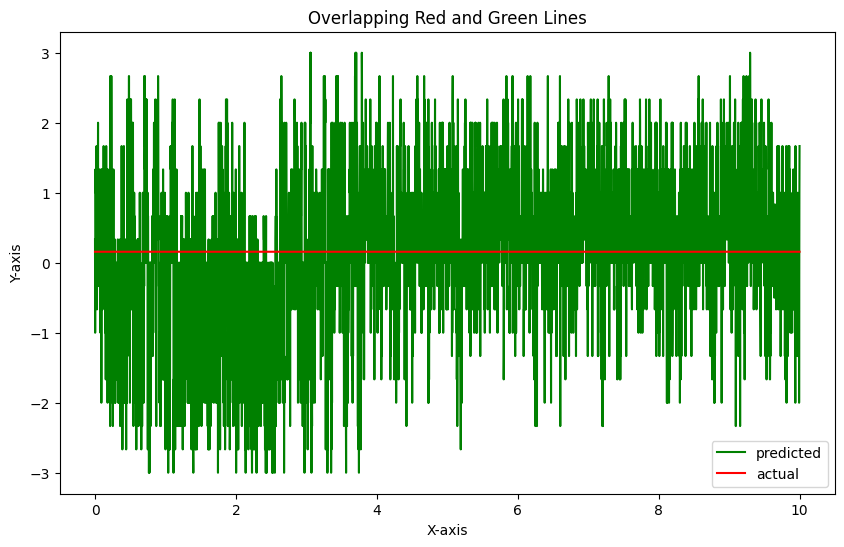

In [129]:
import matplotlib.pyplot as plt

# Sample data (replace these with your actual data)
x = np.linspace(0, 10, 4659)  # Assuming you have 4659 data points
y1 = flatten_2d_array(denormPred)      # Replace with your first array data
y2 = flatten_2d_array(modelTestData['Label_denorm'])      # Replace with your second array data

# Create a figure and axis
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot y1 and y2 as overlapping lines
plt.plot(x, y2, color='green', label='predicted')  # Green line for y2
plt.plot(x, y1, color='red', label='actual')    # Red line for y1

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Overlapping Red and Green Lines')

# Add a legend
plt.legend()

# Show the plot
plt.show()

(array([ 311.,  760., 1125., 1459., 1083., 5715., 3116., 1739.,  811.,
         207.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

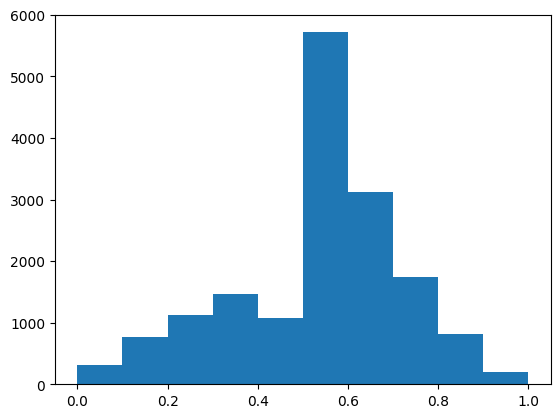

In [130]:
plt.hist(modelTrainData['Label'])